In [1]:
%set_env SHELL=/bin/bash
%set_env OMP_NUM_THREADS=4

env: SHELL=/bin/bash
env: OMP_NUM_THREADS=4


In [2]:
import mbuild as mb
import foyer
import mosdef_cassandra as mc
import unyt as u
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import numpy as np

from scipy.stats import linregress

from mosdef_cassandra.analysis import ThermoProps
from mosdef_cassandra.utils.tempdir import temporary_cd

# Filter some warnings -- to cleanup output for this demo
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)
from parmed.exceptions import OpenMMWarning
filterwarnings('ignore', category=OpenMMWarning)
warnings.filterwarnings('ignore')


mpl.rcParams["axes.linewidth"] =  1.5
mpl.rcParams["axes.grid"] = False

mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.spines.left"] = True
mpl.rcParams["axes.spines.bottom"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.spines.right"] = True

mpl.rcParams["xtick.major.width"] = 1.5
mpl.rcParams["ytick.major.width"] = 1.5
mpl.rcParams["ytick.minor.visible"] = True
mpl.rcParams["xtick.minor.visible"] = True
mpl.rcParams["xtick.minor.width"] = 1.0
mpl.rcParams["ytick.minor.width"] = 1.0
mpl.rcParams["xtick.minor.size"] =  2.5
mpl.rcParams["ytick.minor.size"] =  2.5
mpl.rcParams["xtick.direction"] =  'in'
mpl.rcParams["ytick.direction"] =  'in'
mpl.rcParams["xtick.major.size"] =  5
mpl.rcParams["ytick.major.size"] =  5

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] ='bold'
mpl.rcParams['font.size'] = 12.0
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

%matplotlib inline



def set_ticks(ax, xlinear=True, ylinear=False, xmax=False, ymax=True, yticks = 5, xticks = 5):
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(6))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(6))
    if xlinear: ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(xticks))
    if xmax: ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(xticks))
    if ylinear: ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(yticks))
    if ymax: ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(yticks))


In [3]:
class CentralCH2(mb.Compound):
    def __init__(self):
        super(CentralCH2, self).__init__()
        
        bead = mb.Particle(pos=[0.0, 0.0, 0.0], name='_CH2')
        self.add(bead)
        up_port = mb.Port(anchor=bead, orientation=[0, 0, 1], separation=0.077)
        down_port = mb.Port(anchor=bead, orientation=[0, 0, -1], separation=0.077)
        self.add(up_port, label='up')
        self.add(down_port, label='down')



        
class TerminalCH3(mb.Compound):
    def __init__(self):
        super(TerminalCH3, self).__init__()
        
        bead = mb.Particle(pos=[0.0, 0.0, 0.0], name='_CH3')
        self.add(bead)

        cap_port = mb.Port(anchor=bead, orientation=[0, 0, 1], separation=0.077)
        self.add(cap_port, label='cap')
        
class TerminalCH2(mb.Compound):
    def __init__(self):
        super(TerminalCH3, self).__init__()
        
        bead = mb.Particle(pos=[0.0, 0.0, 0.0], name='_CH2')
        self.add(bead)

        cap_port = mb.Port(anchor=bead, orientation=[0, 0, 1], separation=0.077)
        self.add(cap_port, label='cap')
        
class CentralCH(mb.Compound):
    def __init__(self):
        super(CentralCH2, self).__init__()
        
        bead = mb.Particle(pos=[0.0, 0.0, 0.0], name='_CH')
        self.add(bead)
        up_port = mb.Port(anchor=bead, orientation=[0, 0, 1], separation=0.077)
        down_port = mb.Port(anchor=bead, orientation=[0, 0, -1], separation=0.077)
        self.add(up_port, label='up')
        self.add(down_port, label='down')
        

class TraPPE_Alkane(mb.Compound):
    def __init__(self, chain_length):
        super(TraPPE_Alkane, self).__init__()
        
        terminal_bead = TerminalCH3()
        last_unit = CentralCH2()
        mb.force_overlap(move_this=terminal_bead,
                         from_positions=terminal_bead['cap'],
                         to_positions=last_unit['up'])
        self.add(last_unit)
        self.add(terminal_bead)   
        for _ in range(chain_length - 3):
            current_unit = CentralCH2()
            mb.force_overlap(move_this=current_unit,
                             from_positions=current_unit['up'],
                             to_positions=last_unit['down'])
            self.add(current_unit)
            last_unit=current_unit
        terminal_bead = TerminalCH3()
        
        mb.force_overlap(move_this=terminal_bead,
                         from_positions=terminal_bead['cap'],
                         to_positions=last_unit['down'])
        self.add(terminal_bead, label='down-cap')
        if chain_length < 3:
            print("Note, the shortest chain this function will make is 3")
                     

class TraPPE_Alkene(mb.Compound):
    def __init__(self, chain_length):
        super(TraPPE_Alkane, self).__init__()
        
        terminal_bead = TerminalCH3()
        last_unit = CentralCH2()
        mb.force_overlap(move_this=terminal_bead,
                         from_positions=terminal_bead['cap'],
                         to_positions=last_unit['up'])
        self.add(last_unit)
        self.add(terminal_bead)   
        for _ in range(chain_length - 4):
            current_unit = CentralCH2()
            mb.force_overlap(move_this=current_unit,
                             from_positions=current_unit['up'],
                             to_positions=last_unit['down'])
            self.add(current_unit)
            last_unit=current_unit
            
        current_unit = CentralCH()
        mb.force_overlap(move_this=current_unit,
                         from_positions=current_unit['up'],
                         to_positions=last_unit['down'])
        self.add(current_unit)
        last_unit=current_unit
        
        terminal_bead = TerminalCH2()
        
        mb.force_overlap(move_this=terminal_bead,
                         from_positions=terminal_bead['cap'],
                         to_positions=last_unit['down'])
        self.add(terminal_bead, label='down-cap')
        
        if chain_length < 3:
            print("Note, the shortest chain this function will make is 3")
                

class TraPPE_MeOH(mb.Compound):
    def __init__(self):
        super(TraPPE_MeOH, self).__init__()
        
        methyl = mb.Particle(name='_CH3', pos=[0.0, 0.0, 0.0])
        oxygen = mb.Particle(name='O', pos=[0.0, 0.0, 0.143])
        hydrogen = mb.Particle(name='H', pos=[0.0, 0, 0.143 + 0.0945])

        self.add(methyl)
        self.add(oxygen)
        self.add(hydrogen)
        
        self.add_bond((self[0], self[1]))
        self.add_bond((self[1], self[2]))


In [4]:

adsorbate = TraPPE_MeOH()
ff = foyer.forcefields.load_TRAPPE_UA()
adsorbate_ff = ff.apply(adsorbate)
adsorbate.visualize()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [58]:
gcmc_states = {
    "state1" : {
            "temp": 323.0 * u.K,
            "mu": np.arange(-49, -39, 2) * u.kJ/u.mol,
            "isotherm_pressures": [101325] * u.Pa,
            "isotherm_mus": [],
            "isotherm_loading": [],
        },
    "state2" : {
            "temp": 373.0 * u.K,
            "mu": np.arange(-58, -48, 2) * u.kJ/u.mol,
            "isotherm_pressures": [6000, 22100, 49180, 101325, 121800, 316800, 839700, 2243000, 6000000] * u.Pa,
            "isotherm_mus": [],
            "isotherm_loading": [],
        },
    "state3" : {
            "temp": 423.0 * u.K,
            "mu": np.arange(-58, -48, 2) * u.kJ/u.mol,
            "isotherm_pressures": [101325] * u.Pa,
            "isotherm_mus": [],
            "isotherm_loading": [],
        },
    "state4" : {
            "temp": 473.0 * u.K,
            "mu": np.arange(-68, -58, 2) * u.kJ/u.mol,  
            "isotherm_pressures": [101325] * u.Pa,
            "isotherm_mus": [],
            "isotherm_loading": [],
        },
  
}

custom_args = {
  "rcut_min": 0.5 * u.angstrom,
    "vdw_cutoff": 14.0 * u.angstrom,
    "charge_cutoff": 14.0 * u.angstrom,
    "prop_freq": 1000,
    "coord_freq": 1000,
}



In [59]:

#temperature = np.array([323.0, 373.0, 423.0, 473.0])* u.K
# mus_adsorbate = np.arange(-58, -48, 2) * u.kJ/u.mol
#temperature = np.array([323.0, 423.0, 473.0])* u.K

def run_singlecomponent_gcmc(adsorbate_ff, temp, mu_adsorbate, boxl = 2.5):
        dirname = f'pure_mu_{mu_adsorbate:.1f}_T_{temp:.1f}'.replace(" ", "_").replace("/", "-")
        print(dirname)
        if not os.path.isdir(dirname):
            os.mkdir(dirname)
        else:
            pass
        with temporary_cd(dirname):
            species_list = [adsorbate_ff]
                
            box_list = [mb.Box([boxl,boxl,boxl])]
            system = mc.System(box_list, species_list)
            moveset = mc.MoveSet('gcmc', species_list)

            mc.run(
                system=system,
                moveset=moveset,
                run_type="equil",
                run_length=100000,
                temperature=temp,
                chemical_potentials = [mu_adsorbate],
                **custom_args
            )


for state, conditions in gcmc_states.items():
    for mu in gcmc_states[state]["mu"]:
        if state != "state1":
            l = 5.0
        else:
            l = 7.5
        run_singlecomponent_gcmc(adsorbate_ff, gcmc_states[state]["temp"], mu , boxl = l)
    

            

pure_mu_-49.0_kJ-mol_T_323.0_K
Using the following executables for Cassandra:
Python: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/python
library_setup: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
pure_mu_-47.0_kJ-mol_T_323.0_K
Using the following executables for Cassandra:
Python: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/python
library_setup: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
pure_mu_-45.0_kJ-mol_T_323.0_K
Using the following executables for Cassandra:
Python: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/python
library_setup: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/Woody/Programs/miniconda3/envs/ca

Slope: 3.236845272172225
Intercept: -42.38604312573708
We will run at mu = -42.34 kJ/mol to simulate 101325 Pa at 323.0 K
Slope: 2.6947370879513506
Intercept: -51.13623258283153
We will run at mu = -58.72 kJ/mol to simulate 6000 Pa at 373.0 K
We will run at mu = -55.20 kJ/mol to simulate 22100 Pa at 373.0 K
We will run at mu = -53.05 kJ/mol to simulate 49180 Pa at 373.0 K
We will run at mu = -51.10 kJ/mol to simulate 101325 Pa at 373.0 K
We will run at mu = -50.60 kJ/mol to simulate 121800 Pa at 373.0 K
We will run at mu = -48.03 kJ/mol to simulate 316800 Pa at 373.0 K
We will run at mu = -45.40 kJ/mol to simulate 839700 Pa at 373.0 K
We will run at mu = -42.75 kJ/mol to simulate 2243000 Pa at 373.0 K
We will run at mu = -40.10 kJ/mol to simulate 6000000 Pa at 373.0 K
Slope: 3.42291344119851
Intercept: -58.715103801057175
We will run at mu = -58.67 kJ/mol to simulate 101325 Pa at 423.0 K
Slope: 3.7997660863363576
Intercept: -66.5776261022718
We will run at mu = -66.53 kJ/mol to simulat

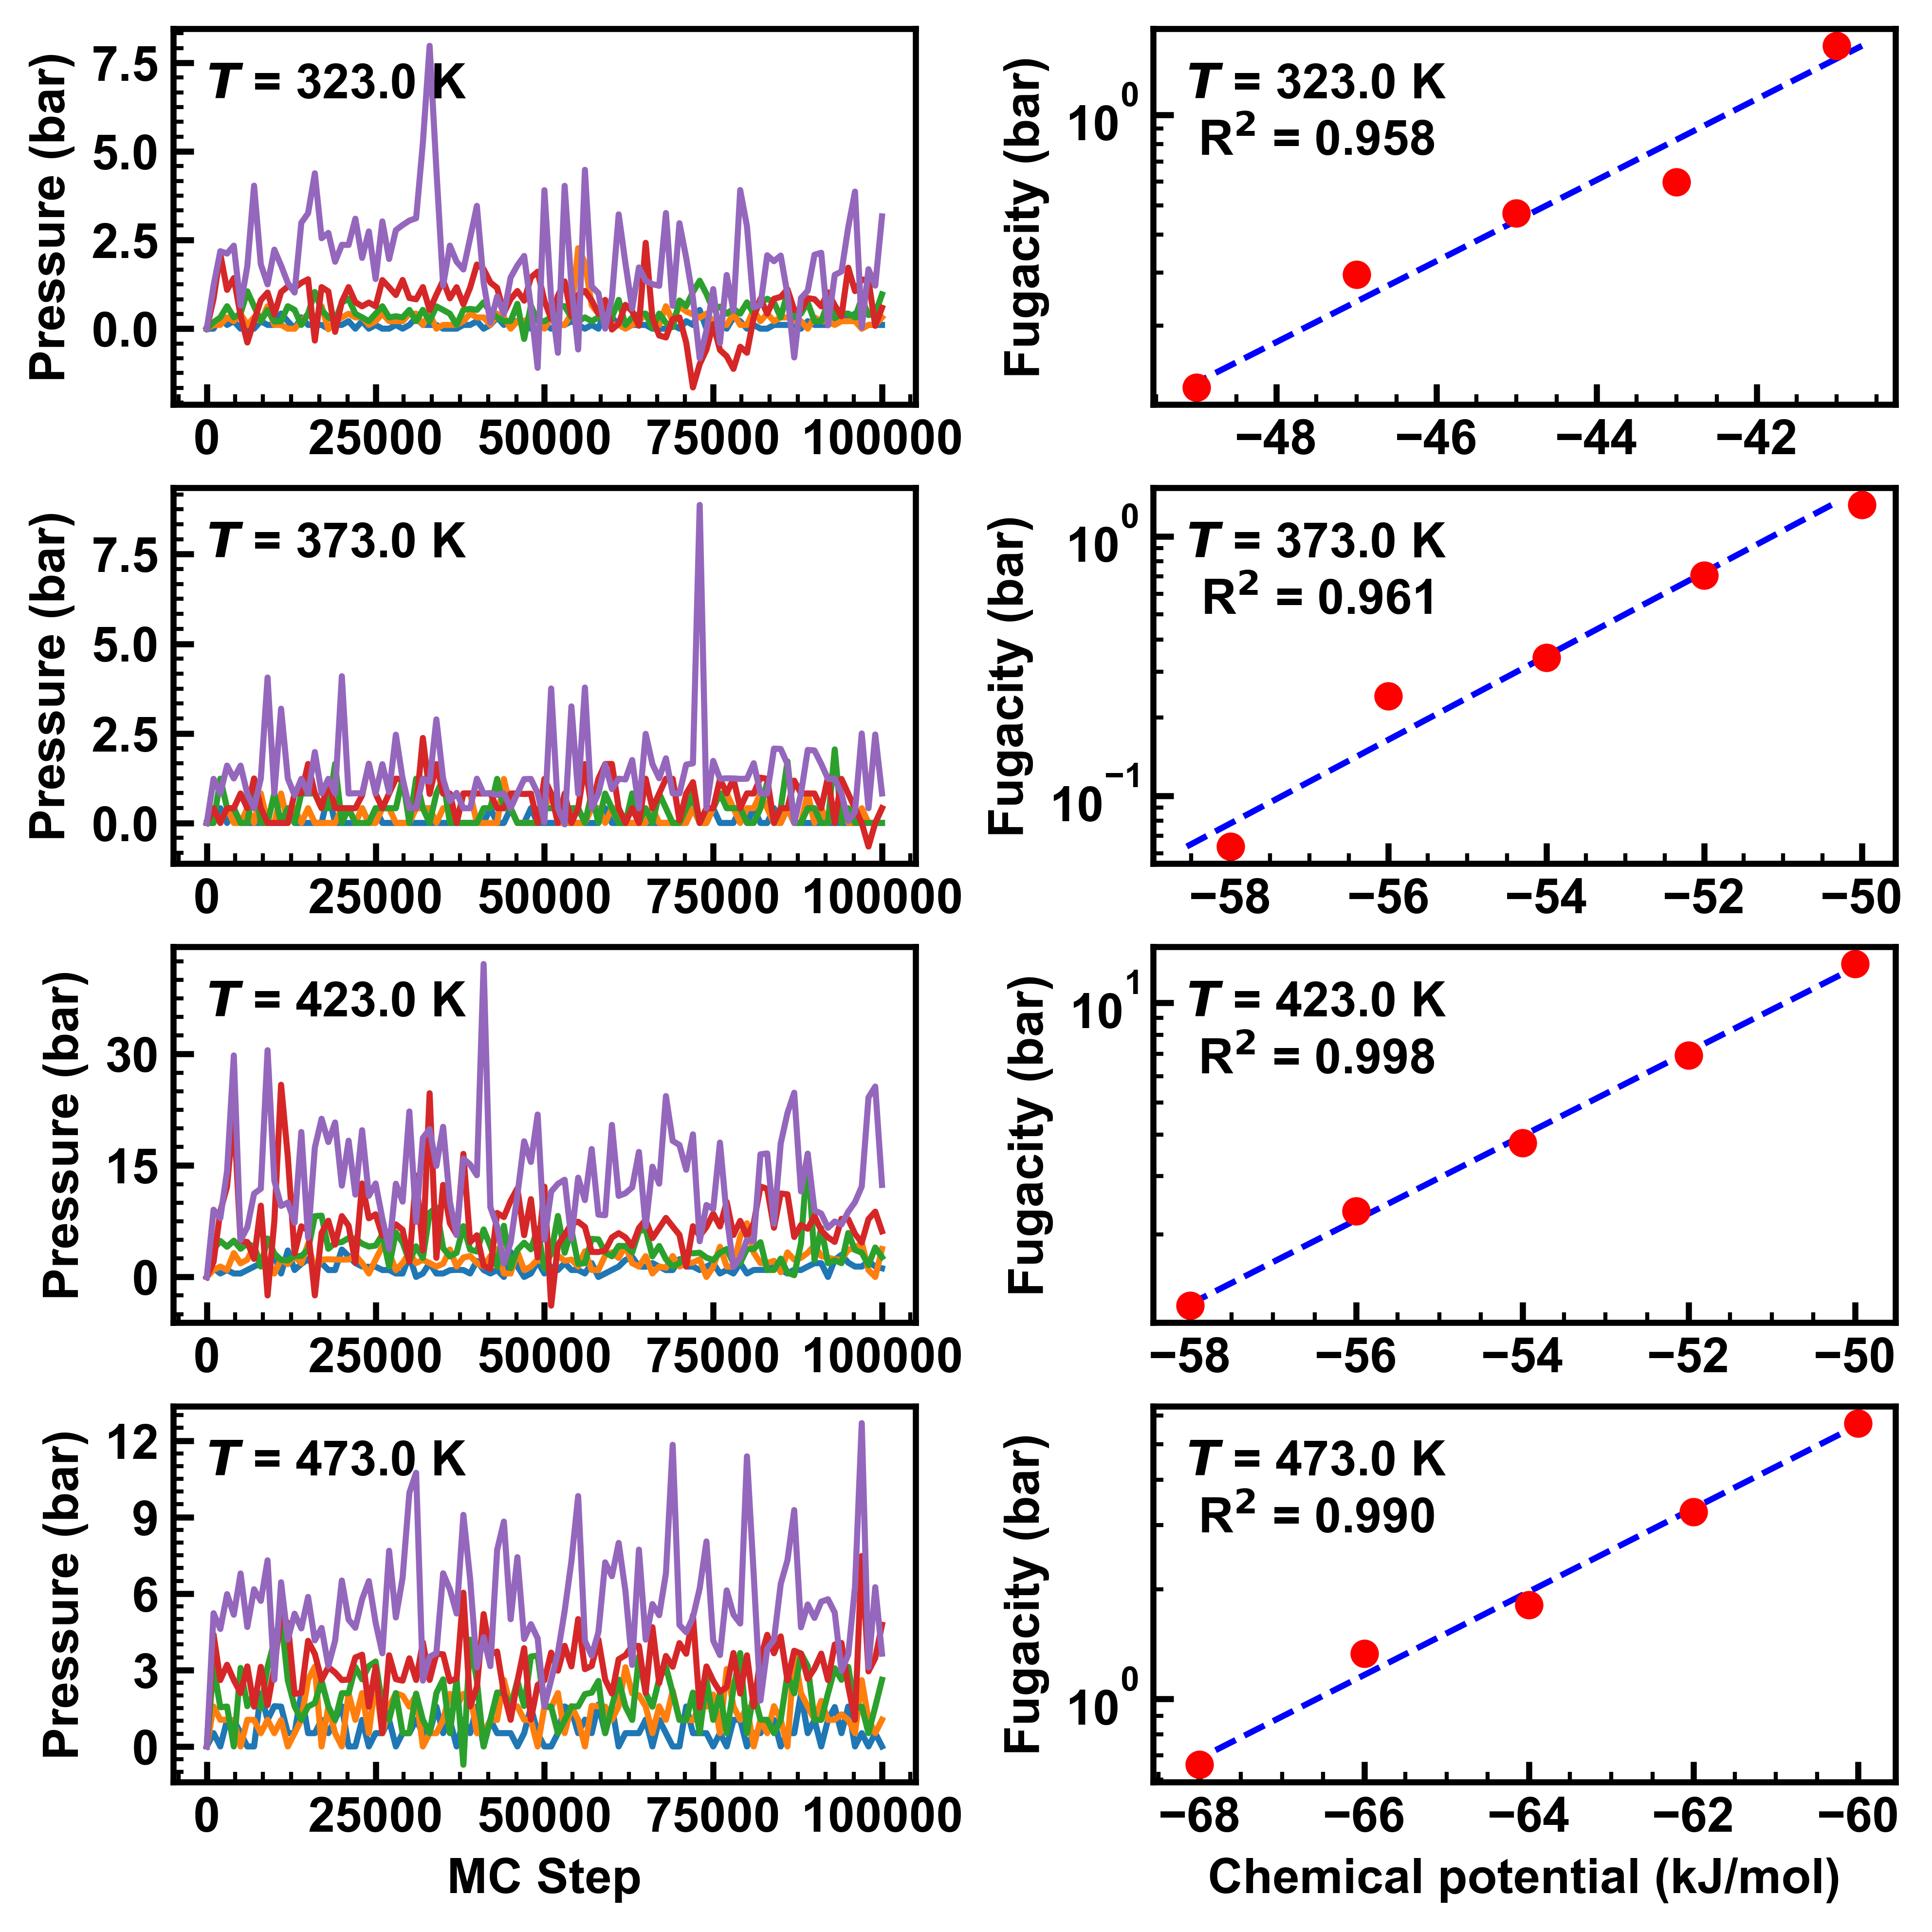

In [60]:


fig, axs = plt.subplots(nrows = 4, ncols = 2, dpi = 600, figsize = (6.5, 6.5), layout = "constrained", sharex = False)


def plot_nmols_vs_time(ax, temperature, mus_adsorbate):

    nmols = []
    for mu_adsorbate in mus_adsorbate:
        dirname = f'pure_mu_{mu_adsorbate:.1f}_T_{temperature:.1f}'.replace(" ", "_").replace("/", "-")
        thermo = ThermoProps(dirname + "/gcmc.out.prp")
        nmols.append(np.mean(thermo.prop("Nmols", start=30000)))
        ax.plot(thermo.prop("MC_STEP"), thermo.prop("Nmols"))
        ax.set_title(temperature)
    set_ticks(ax,  xlinear=False, ylinear=False, xmax=True, ymax=True,)


def plot_pressures_vs_time(ax, temperature, mus_adsorbate):

    pressures = []
    for mu_adsorbate in mus_adsorbate:
        dirname = f'pure_mu_{mu_adsorbate:.1f}_T_{temperature:.1f}'.replace(" ", "_").replace("/", "-")
        thermo = ThermoProps(dirname + "/gcmc.out.prp")
        pressures.append(np.mean(thermo.prop("Pressure", start=30000)))
        ax.plot(thermo.prop("MC_STEP"), thermo.prop("Pressure"))



    ax.text(
        0.22, 0.85,
        f"$T$ = {temperature}",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes,
    )
    set_ticks(ax,  xlinear=False, ylinear=False, xmax=True, ymax=True,)
    return pressures



def plot_eos(ax, pressures, mus_adsorbate, temp, isotherm_pressures):
    slope, intercept, r_value, p_value, stderr = linregress(np.log(pressures).flatten(),y=mus_adsorbate.flatten())
    
    mus_eos = (slope * np.log(pressures) + intercept) * u.kJ/u.mol
    ax.plot(mus_eos, pressures, 'b--')
    ax.plot(mus_adsorbate, pressures, 'ro')

    ax.set_yscale('log')
    
    print("Slope:", slope)
    print("Intercept:", intercept)
    
    ax.text(
        0.22, 0.85,
        f"$T$ = {temp}",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes,
    )


    ax.text(
        0.22, 0.7,
        f"R$^2$ = {r_value * r_value:.3f}",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes,
    )



    mus = (slope * np.log(isotherm_pressures.in_units(u.bar)) + intercept) * u.kJ/u.mol
    for (mu, pressure) in zip(mus, isotherm_pressures):
        print(f"We will run at mu = {mu:0.2f} to simulate {pressure:0.0f} at {temp}")
    return mus
    


i = 0
for state, conditions in gcmc_states.items():
    p = plot_pressures_vs_time(axs[i][0], conditions["temp"], conditions["mu"])
    gcmc_states[state]["isotherm_mus"] = plot_eos(axs[i][1], p, conditions["mu"], conditions["temp"], conditions["isotherm_pressures"])
    i += 1

axs[-1][0].set_xlabel("MC Step")
axs[-1][1].set_xlabel("Chemical potential (kJ/mol)")

for ax in axs[:,0]:
    ax.set_ylabel("Pressure (bar)")

for ax in axs[:,1]:
    ax.set_ylabel("Fugacity (bar)")

    
pass

In [63]:
custom_args = {
  "rcut_min": 0.5 * u.angstrom,
    "vdw_cutoff": 14.0 * u.angstrom,
    "charge_cutoff": 14.0 * u.angstrom,
    "prop_freq": 4000,
    "coord_freq": 4000,
}

def run_gcmc_density(pressures, mus, temperature):
    for (pressure, mu) in zip(pressures, mus):
        dirname = f'pure_press_{pressure.value:0.0f}_T_{temperature:.1f}'.replace(" ", "_").replace("/", "-")
        if not os.path.isdir(dirname):
            os.mkdir(dirname)
        else:
            pass
        with temporary_cd(dirname):
            box_list = [mb.Box([5.0, 5.0, 5.0])]
        
            species_list = [adsorbate_ff]
            system = mc.System(box_list, species_list)
            moveset = mc.MoveSet('gcmc', species_list)
        
            mc.run(
                system=system,
                moveset=moveset,
                run_type="equil",
                run_length=20000000,
                temperature=temperature,
                chemical_potentials = [mu],
                **custom_args
            )


i = 0
for state, conditions in gcmc_states.items():
    if state == "state2":
        run_gcmc_density([conditions["isotherm_pressures"][3]], [conditions["isotherm_mus"][3]],  conditions["temp"])
    else:
        run_gcmc_density(conditions["isotherm_pressures"], conditions["isotherm_mus"],  conditions["temp"])
        


Using the following executables for Cassandra:
Python: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/python
library_setup: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/python
library_setup: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/python
library_setup: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the fol

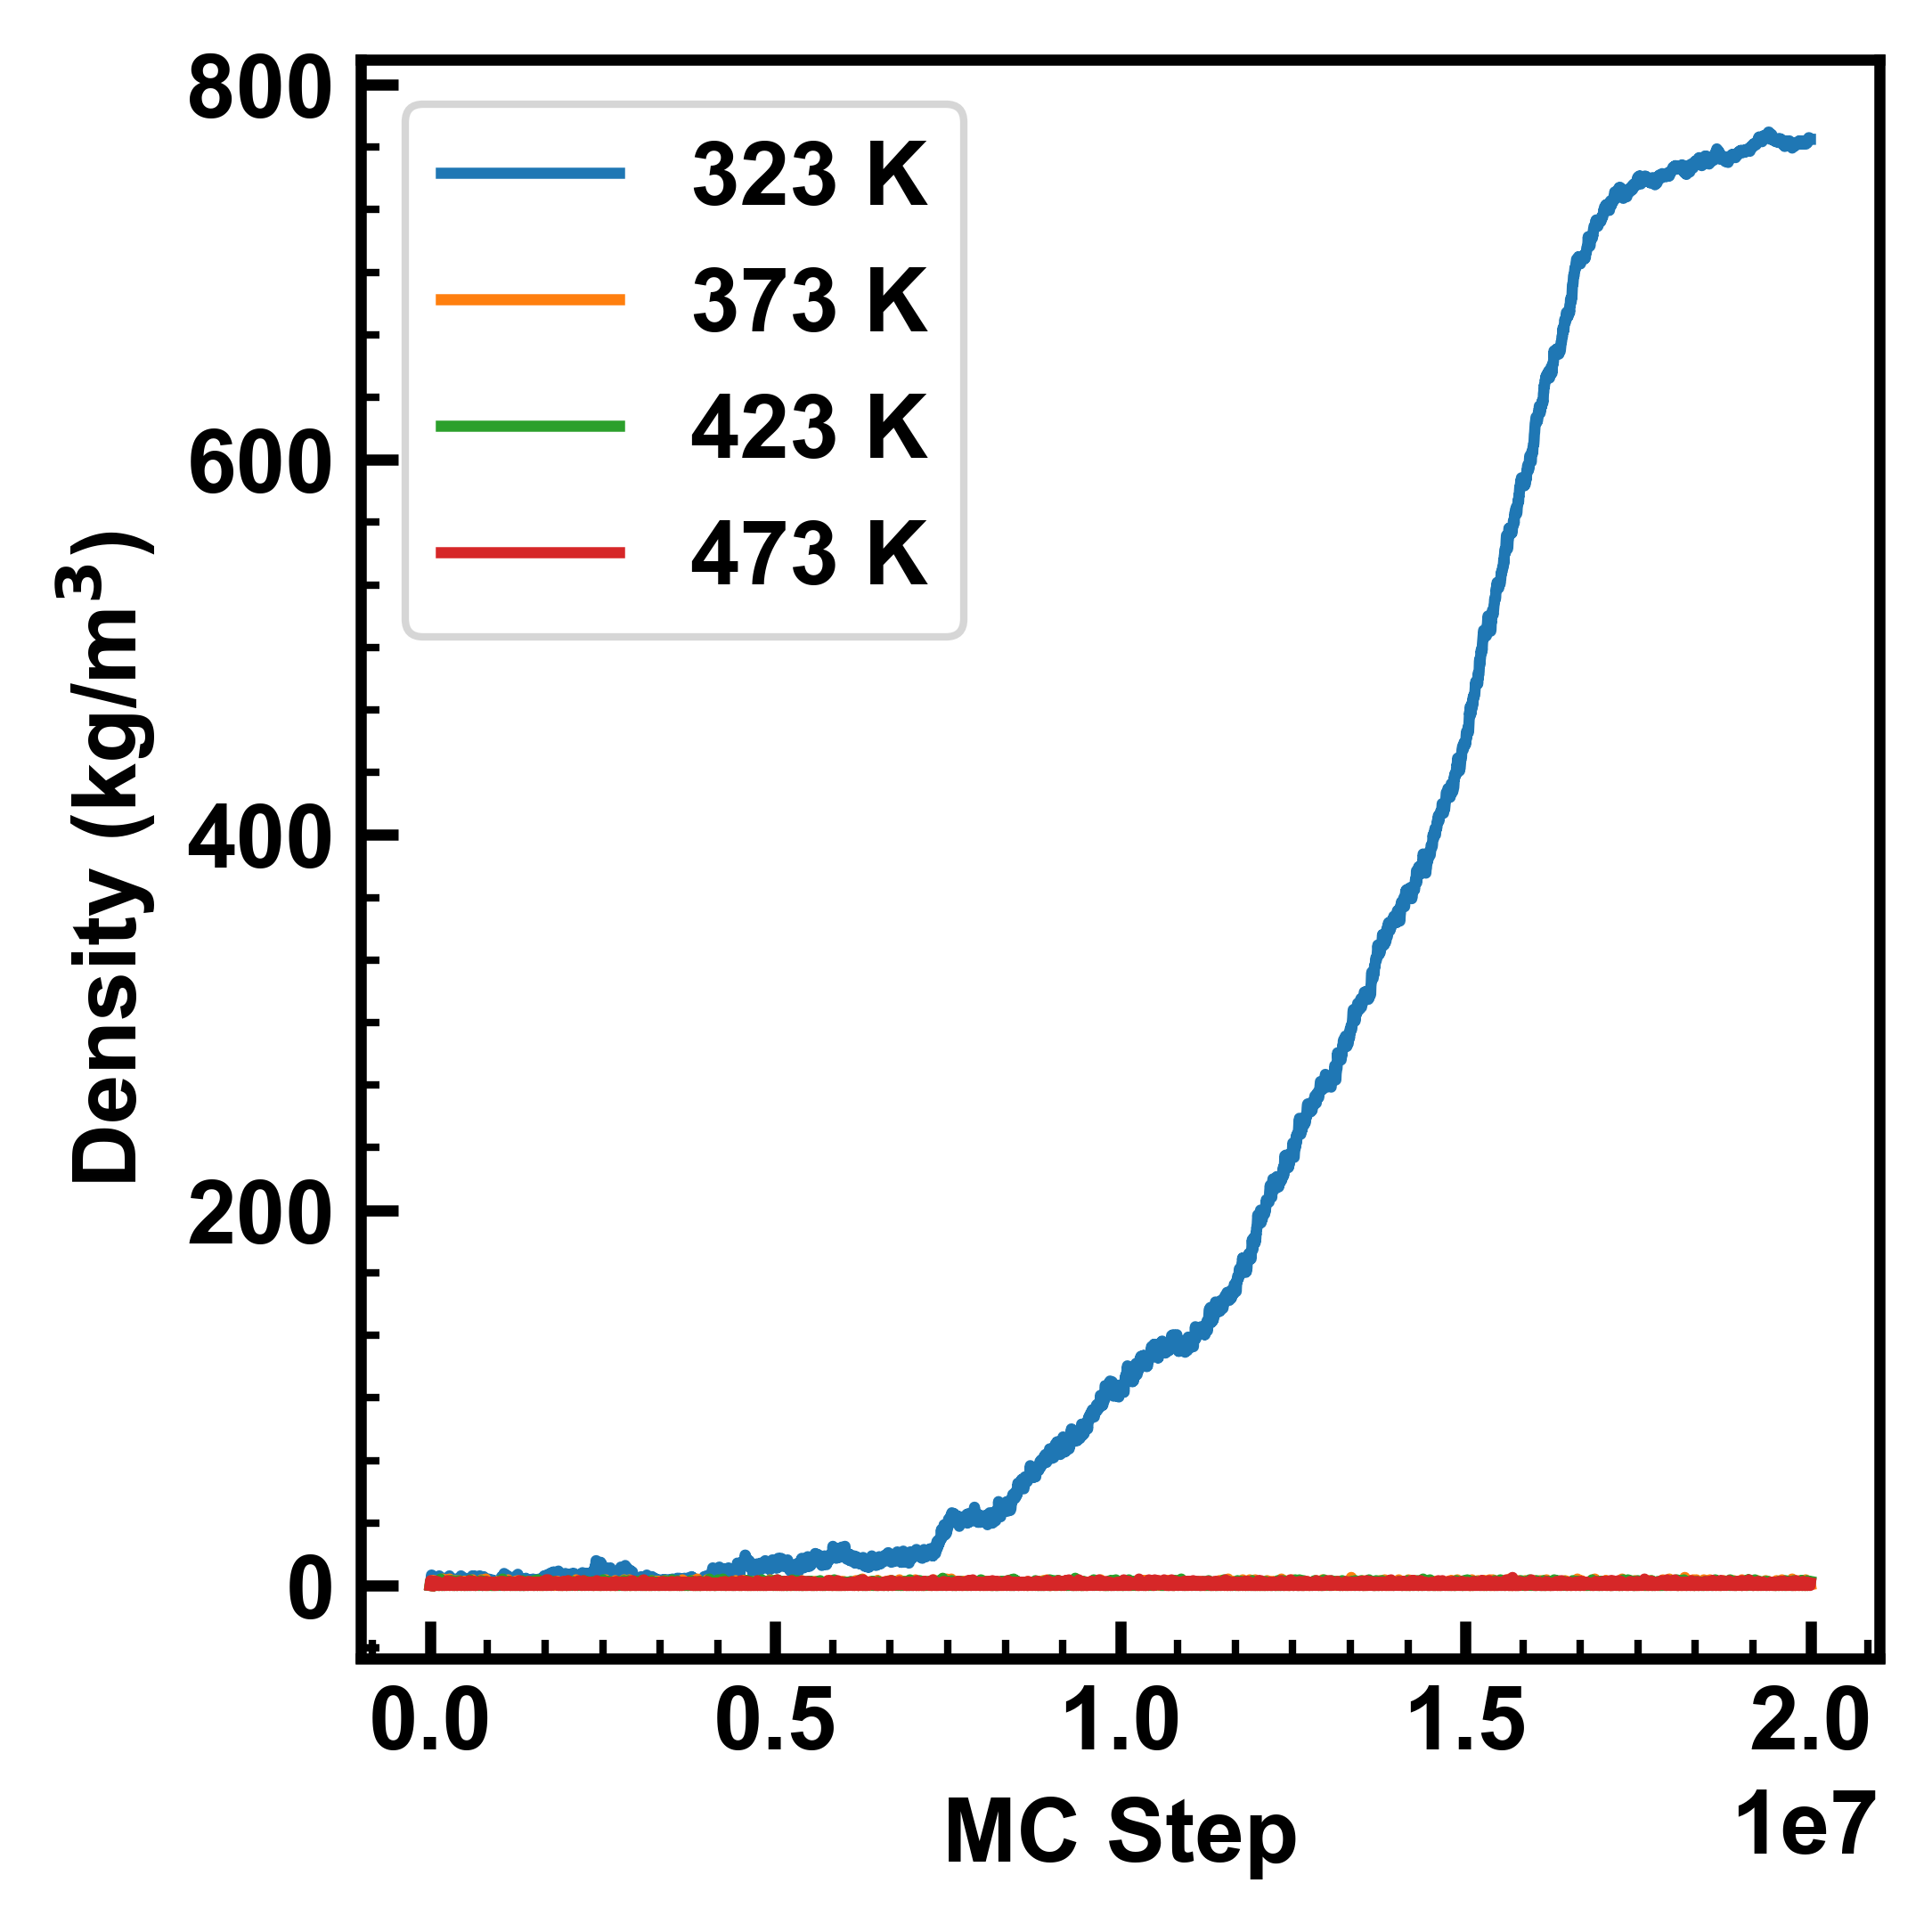

In [67]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi = 600, figsize = (3.5, 3.5), layout = "constrained")

density = []
for state, conditions in gcmc_states.items():

    temperature = conditions["temp"]
    dirname = f'pure_press_101325_T_{temperature:.1f}'.replace(" ", "_").replace("/", "-")
    thermo = ThermoProps(f"{dirname}/gcmc.out.prp")
    density.append(np.mean(thermo.prop("Mass_Density", start=15000000)))
    ax.plot(thermo.prop("MC_STEP"), thermo.prop("Mass_Density"), label=f"{temperature:0.0f}")
    
#ax.set_title(f"T = {temperature:0.1f}", fontweight="bold")
ax.set_xlabel('MC Step')
ax.set_ylabel('Density (kg/m$^3$)')
set_ticks(ax,  xlinear=False, ylinear=False, xmax=True, ymax=True,)

#fig.legend(loc='outside center right', ncol=1)
ax.legend(ncol=1)
fig.savefig("density_scan.png", transparent = True)




In [29]:
for p, r in zip(pressures, density):
    print(p, r)
    mw = 32.041999999999994 # g/mol

    boxl  = ((mw / 6.022140857e23) / (r.value/1e30 * 1000.0))**(1 / 3.) # angstrom
    print(boxl)

101325 Pa 1.1075226653237409 dimensionless
36.352869267722845
